<a href="https://colab.research.google.com/github/FarahYusri12/Warfarin_Dosing_Prediction-Model_Comparison/blob/main/Gradient_Boosting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
import pandas as pd
import numpy as np

df=pd.read_csv('Preprocessed_data.csv')
print(df.head())
print("\n" + "="*100 + "\n")
print(df.info())

            ID Age (years)  Gender  Weight (kg)  Height (cm)  Dose (mg)  \
0  PA135312261     60 - 69    Male        115.7       193.04       49.0   
1  PA135312262     50 - 59  Female        144.2       176.53       42.0   
2  PA135312263     40 - 49  Female         77.1       162.56       53.0   
3  PA135312264     60 - 69    Male         90.7       182.24       28.0   
4  PA135312265     50 - 59    Male         72.6       167.64       42.0   

  CYP2C9 VKORC1 (rs9923231; C/T)  Gender_code  CYP2C9_code  VKORC1_code   Age  
0  *1/*1                     A/G            1            0            1  64.5  
1  *1/*1                     A/A            0            0            2  54.5  
2  *1/*1                     G/G            0            0            0  44.5  
3  *1/*1                     A/G            1            0            1  64.5  
4  *1/*3                     A/G            1            1            1  54.5  


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3419 entries, 0 t

In [16]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor

In [17]:
# Separate data

x=df[['Age', 'VKORC1_code', 'CYP2C9_code', 'Gender_code', 'Weight (kg)', 'Height (cm)']]
y=df['Dose (mg)']

# Train test split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [18]:
#===============
# Pipeline setup
#===============

pipeline=Pipeline([
    ('scaler', StandardScaler()),
    ('model', GradientBoostingRegressor(random_state=42))
])

In [19]:
#=====================================
# GridSearchCV for hyperparameter grid
#=====================================

param_grid={
    'model__n_estimators': [100,200,500],
    'model__learning_rate': [0.01, 0.05, 0.1],
    'model__max_depth': [2,3,4]
}

grid=GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring= 'neg_mean_absolute_error',
    cv=5, n_jobs=-1
)
grid.fit(x_train, y_train)

print("Best parameter:", grid.best_params_)
print("Best Mae:", grid.best_score_)

Best parameter: {'model__learning_rate': 0.05, 'model__max_depth': 3, 'model__n_estimators': 100}
Best Mae: -8.711747052472573


In [20]:
#=======================
# Evaluation
#=======================

best_model=grid.best_estimator_
y_pred=best_model.predict(x_test)

mae=mean_absolute_error(y_test, y_pred)
mse=np.sqrt(mean_squared_error(y_test,y_pred))
r2=r2_score(y_test,y_pred)

print("Model performance:")
print(f"Mae : {mae:.2f}")
print(f"Rmse: {mse:.2f}")
print(f"R2  : {r2:.2f}")

Model performance:
Mae : 8.73
Rmse: 12.70
R2  : 0.43


In [21]:
#========================
# Permutation Importance
#========================

perm_importance=permutation_importance(
    best_model,
    x_test,
    y_test,
    n_repeats=10,
    random_state=42
)
feature_important= pd.DataFrame({
    'Feature':x_test.columns,
    'Importance_mean':perm_importance.importances_mean,
    'Importance_std': perm_importance.importances_std
}).sort_values(by='Importance_mean', ascending=False)

print("permutation importance:")
print(feature_important)

permutation importance:
       Feature  Importance_mean  Importance_std
1  VKORC1_code         0.414971        0.025246
4  Weight (kg)         0.129342        0.020720
0          Age         0.090847        0.023539
2  CYP2C9_code         0.077158        0.009771
5  Height (cm)         0.036847        0.026264
3  Gender_code         0.001760        0.001631


Visualization

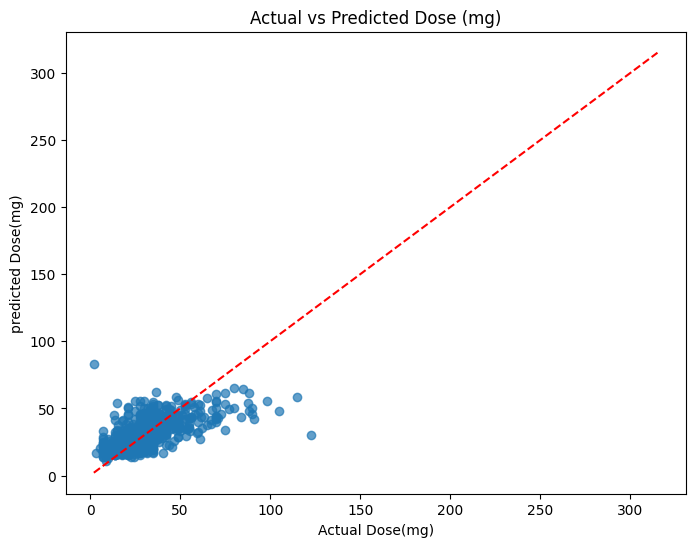

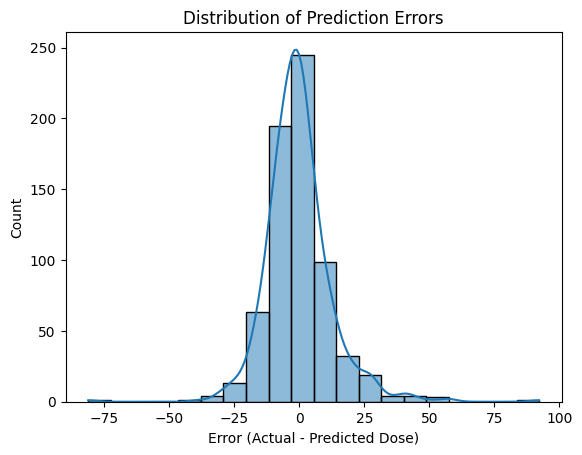

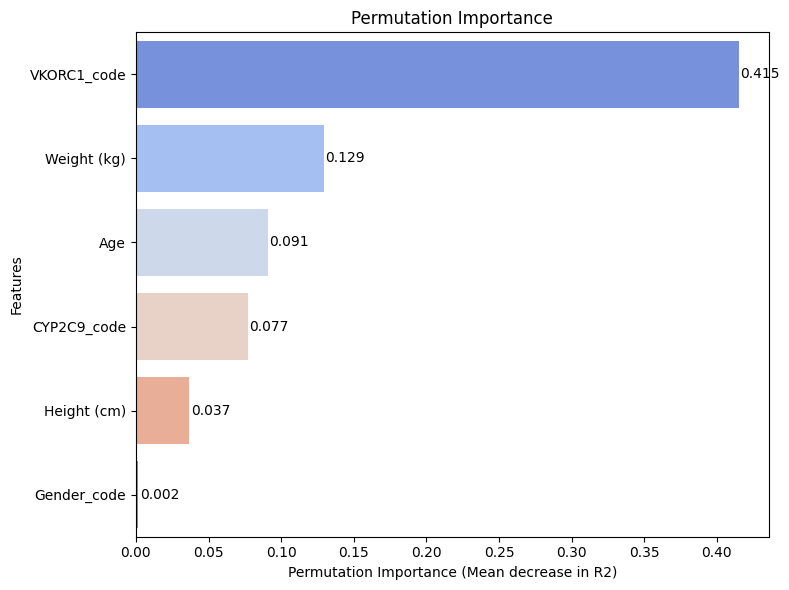

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
# Scatter plot actual vs predicted
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.xlabel("Actual Dose(mg)")
plt.ylabel("predicted Dose(mg)")
plt.title("Actual vs Predicted Dose (mg)")
plt.plot([y.min(), y.max()], [y.min(), y.max()], color="red", linestyle="--")
plt.show()

print("\n" + "="*100 + "\n")

# Distribution plot error
errors=y_test-y_pred
sns.histplot(errors, bins=20, kde=True)
plt.xlabel("Error (Actual - Predicted Dose)")
plt.title("Distribution of Prediction Errors")
plt.show()

print("\n" + "="*100 + "\n")

# Permutation importance bar plot
plt.figure(figsize=(8,6))
ax=sns.barplot(
    x="Importance_mean",
    y="Feature",
    data=feature_important,
    hue="Feature",
    palette="coolwarm",
    legend=False
)

plt.xlabel("Permutation Importance (Mean decrease in R2)")
plt.ylabel("Features")
plt.title("Permutation Importance")
for container in ax.containers:
    ax.bar_label(container, fmt="%.3f", label_type="edge", padding=1)

plt.tight_layout()
plt.show()

In [24]:
result={
    'Model':'Gradient Boosting',
    'R2':r2,
    'MAE':mae,
    'RMSE':mse
}
pd.DataFrame([result]).to_csv('Gradient_Boosting_result.csv', index=False)
print('done')

done
